# 10. 도로 영역을 찾자! - 세그멘테이션 모델 만들기

![](https://d3s0tskafalll9.cloudfront.net/media/images/68747470733a2f2f.max-800x600.png)

Semantic Segmenation을 이용해서 자율주행 차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보자.   
U-Net을 사용해서 이미지가 입력되면 도로의 영역을 Segmentation 하는 모델을 만들어보자.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/result.gif)

최종적으로 만들어볼 모델의 gif이다.   
입력 이미지 위에 도로 영역으로 인식한 영역을 흰색으로 오버레이 한 이미지다.

# 10-2. 시맨틱 세그멘테이션 데이터셋

### 이미지 가져오기
먼저 semantic segmentation으로 도로의 영역을 분리하기 위해 도로의 영역을 라벨로 가진 데이터셋을 갖고 학습할 수 있도록 파싱해야한다.   
object detection으로 사용했던 KITTI 데이터셋의 세그멘테이션 데이터를 다운로드하자.

출처: [http://www.cvlibs.net/datasets/kitti/eval_semantics.php](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)

```
!cd /content/drive/MyDrive/aiffel_dataset/GD10_semantic_segmenation/
!wget https://www.dropbox.com/s/thhq5312hdwo494/KITTI.zip
!unzip KITTI.zip
```

![](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10.max-800x600.png)   
KITTI dataset

![](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10_label.max-800x600.png)   
KITTI dataset segmenatation

![](https://d3s0tskafalll9.cloudfront.net/media/images/000002_10_mqPgQu0.max-800x600.png)   
KITTI dataset segmentation_rgb

라벨 정보는 [깃허브](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)에서 확인할 수 있다. 이번에 찾아야 하는 road는 7이다.

### 데이터 loader 만들기
이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터로더를 만들어보자.   
loader는 입력값 `(224,224)`, 출력값 `(224,224)` 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야한다.

데이터 로더에 augmentation을 적용해보자. 파이썬에서 많이 사용되는 albumentations를 사용해보자. imgaug 등 다른 라이브러리를 활용해도 된다.

또한 학습셋의 일정량을 validation dataset으로 활용해야한다는 점을 인지하자.

In [15]:
# 클라우드는 1.1.0 버전이다. 만약 오류가 난다면 확인하자.
!pip list | grep albumentations

albumentations                0.1.12


augmentation을 만든 후 직접 데이터셋이 잘 파싱되어 나오는지 꼭 확인해봐야한다.   
데이터셋에 오류가 없어야 성능이 안나오더라도 문제를 찾아내기 쉽다.

In [16]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


Albumentation의 사용법을 알아보자.   
Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있는 Compose()의 활용 예시이다. imgaug의 Sometimes()와 유사한 기능이다.

In [17]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

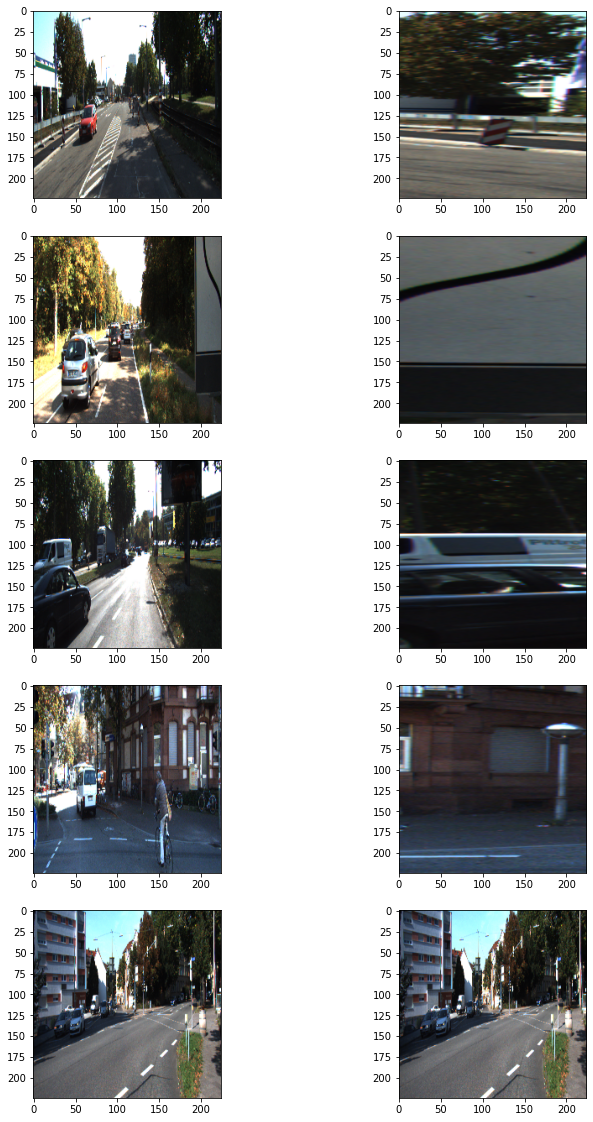

In [18]:
dir_path = '/content/drive/MyDrive/aiffel_dataset/GD10_semantic_segmenation/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해보자.

In [19]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [20]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 10-3. 시맨틱 세그멘테이션 모델
![](https://d3s0tskafalll9.cloudfront.net/media/images/u-net_1kfpgqE.max-800x600.png)

### 모델 구조 만들기
시맨틱 세그멘테이션을 위한 모델로 `U-Net`을 구현해보자.

입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들어야한다.

Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout 등의 연산을 사용해서 구현하자.

In [21]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### 모델 학습하기
데이터셋과 모델을 통해 학습해보자.

학습하는데 너무 오래 걸려 미리 준비된 모델을 불러와 사용하자.

In [22]:
# model_path = '/content/drive/MyDrive/aiffel_dataset/GD10_semantic_segmenation/training/seg_model_unet.h5'

# model = build_model()
# model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
# model.fit(
#      train_generator,
#      validation_data=test_generator,
#      steps_per_epoch=len(train_generator),
#      epochs=100,
#  )

# model.save(model_path)  #학습한 모델을 저장해 주세요.

model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

# 10-4. 시맨틱 세그멘테이션 모델 시각화

테스트셋은 이미지를 제공하지만 정답 데이터를 제공하지 않아 눈으로 확인할 수 있도록 모델이 inference(추론)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어보자.

이때 입력 이미지와 라벨을 한 번에 볼 수 있게 모델의 출력값을 입력 이미지 위에 겹쳐서 보이는 overray를 해보자.   
PIL 패키지를 사용하면 Image.blend를 활용할 수 있다.

In [23]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

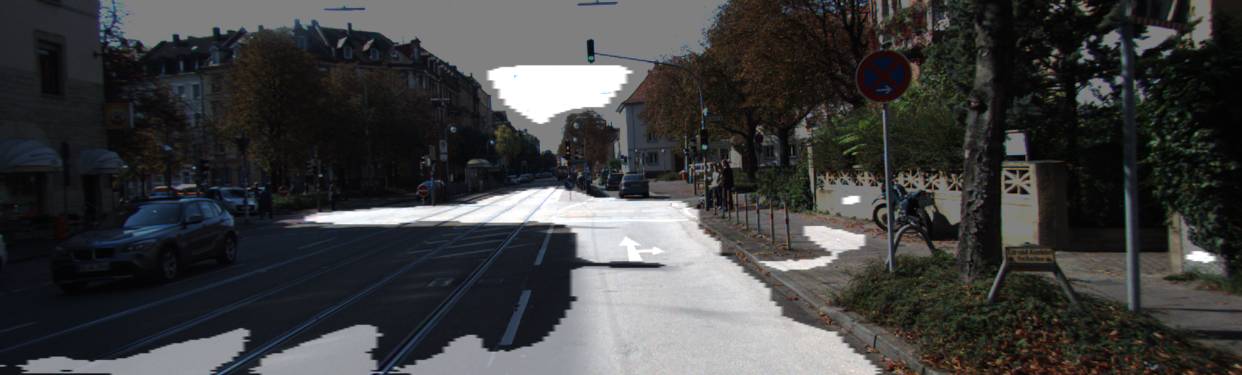

In [24]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션 성능을 정량적으로 측정하기 위한 방법으로 IoU를 계산하게 된다.

IoU를 계산하려면 모델이 도로 영역이라 판단한 부분이 1, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 0으로 표시된 행렬이 필요하다.   
각각 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현해보자.

`get_output`을 확장해서 output, prediction, target을 함께 리턴하도록 구현해보자.

In [25]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [26]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [27]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

# 10-5. 프로젝트 개선된 U-Net 모델 만들기
U-Net으로 도로 시맨틱 세그멘테이션을 진행해봤다.   
개선할 여지도 보인다.

2018년에 U-Net++ 논문이 나왔다. 기존 U-Net 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델이다. 그리고 논문은 2020년에 한 번 업그레이드 되었다.

- [U-Net++: v1](https://arxiv.org/abs/1807.10165)
- [U-Net++: v2](https://arxiv.org/abs/1912.05074)

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png)

모델의 구조를 그림으로 표현했다. 오늘 배운 U-Net의 모델 코드를 조금만 수정 확장하면 구현할 수 있을것이다.   
그래서 이번 과제는 U-Net++ 모델을 스스로의 힘으로 구현해보고, U-Net을 활용한 도로 세그멘테이션 태스크에 적용하여 U-Net을 사용했을 때보다 성능이 향상되었음을 확인해보자.   
정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해볼 수 있고, 정량적으로는 동일 이미지에 대한 IoU 값을 비교해보자.

- [U-Net++:Github](https://github.com/MrGiovanni/UNetPlusPlus)
참고할 수 있는 코드이다.

코드에서 가장 중요한 부분은 [build_xnet](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12)이다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/gc-5v2-p-4-1.max-800x600.png)
그리고 논문에서 제시하는 수식이다. $H, u, []$가 무엇인지 주목해보자.

코드 중 `up_block`으로 두 가지 방식을 사용하고 있다.   
[Transpose2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L53), [Upsample2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L28)인데, 둘 중 어느것을 사용해도 괜찮다.

주의해야 할 점은 Loss를 조금 다르게 구현해야한다.   
binary cross-entropy와 dice coefficient를 사용하는데, [dice_coef](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)에 구현된 dice coefficient를 참고해보자.

![](https://d3s0tskafalll9.cloudfront.net/media/images/gc-5v2-p-4-2.max-800x600.png)